# Exercise 1

In this exercise we are going to learn in practice how Linear Regression works.

Before running the code, please refer to [this link](https://pytorch.org/get-started/locally/) to install PyTorch using the appropriate command for your system.

You also need to install the `matplotlib` library using the following command:

```bash
pip install matplotlib
```

In [6]:
import torch

torch.manual_seed(42)

# Set the device to be used for training. If a GPU is available, use it. Otherwise, use the CPU.
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Plotting Utils

Plotting is quite important in machine learning which helps us quickly get intuition from enormous data points and gain intuition. Plus they also do good to your illustration. Matplotlib is one of the most commonly used plotting libraries in python. 

Seaborn, Nineplot and Plotly are also powerful and it's important to master at least one of them. 

In [7]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import rc

## Creating Toy Data

We have prepared the toy data for you. But do not just skip this part! Skim through it and think:

- Why are we declaring a known function and add random noise to samples from it? What are the practical counterparts of them?

- Why do we choose Gaussian distribution as the noise instead of the other distributions?

In [8]:
def func(x):
    return 2 * x + 1

def create_toy_data(func, interval, sample_num, noise = 0.0, add_outlier = False, outlier_ratio = 0.001):
    """
    generate data with the given function
    
    input:
       - func: the input function
       - interval: the range of values of x, a tuple (start, end)
       - sample_num: number of samples
       - noise: the standard deviation of Gaussian noise
       - add_outlier: whether to generate outliers
       - outlier_ratio: proportion of outliers
       
    output:
       - X: samples, shape = [n_samples,1]
       - y: labels, shape = [n_samples,1]
    """
    
    X = torch.rand(sample_num,1, device=device) * (interval[1]-interval[0]) + interval[0]
    y = func(X)

    # add Gaussian noise
    epsilon = torch.normal(0, noise, (sample_num,1), device=device)
    y = y + epsilon
    
    # add outlier
    if add_outlier:
        outlier_num = int(sample_num * outlier_ratio)
        if outlier_num != 0:
            outlier_idx = torch.randint(sample_num, size = [outlier_num,1], device=device)
            y[outlier_idx] = y[outlier_idx] * 5
            
    return X, y

The black line in the following figure stands for the underlying data distribution, circles for trainig data and triangles for test data.

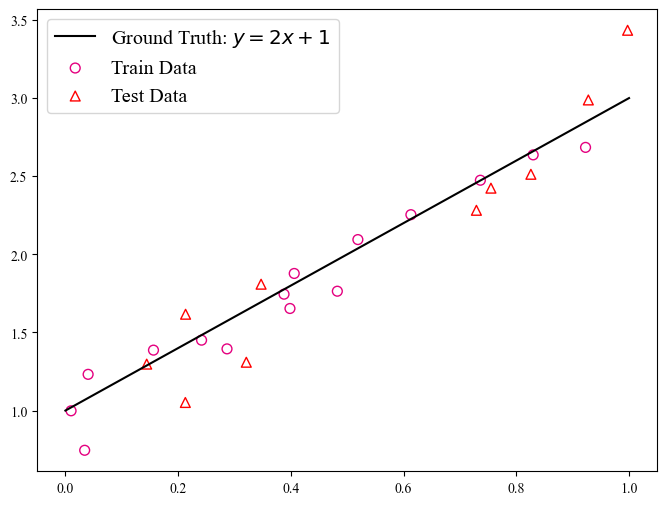

In [9]:
interval = (0,1)
train_num = 15
test_num = 10
noise = 0.2
X_train, y_train = create_toy_data(func=func, interval=interval, sample_num=train_num, noise=noise)
X_test, y_test = create_toy_data(func=func, interval=interval, sample_num=test_num, noise=noise)

X_underlying = torch.linspace(interval[0],interval[1],100, device=device)
y_underlying = func(X_underlying)

# plot
"""_summary_ draw the plot of the underlying function and the training and test data"""
rc('font', family='times new roman')
plt.rcParams['figure.figsize'] = (8.0, 6.0)
plt.plot(X_underlying.cpu(), y_underlying.cpu(), c='#000000', label=r"Ground Truth: $y = 2x + 1$")
plt.scatter(X_train.cpu(), y_train.cpu(), facecolor="none", edgecolor='#e4007f', s=50, label="Train Data")
plt.scatter(X_test.cpu(), y_test.cpu(), facecolor="none", edgecolor="r", marker = '^', s=50, label="Test Data")
plt.legend(fontsize='x-large')
plt.show()

## Using PyTorch for Linear Regression

PyTorch is a powerful deep learning framework which is widely used in academia and industry. It is also a good tool for learning machine learning. In this exercise, we are going to use PyTorch to implement a simple linear regression model.

We are going to use two methods to implement the linear regression model. The first one is to use the closed-form solution, and the second one is to use the gradient descent algorithm.

## Closed-form Solution without Bias

Here we present an example of using the closed-form solution to solve a $y = ax$-style linear regression problem without bias. The closed-form solution is as follows:

$$
\theta = (X^TX)^{-1}X^TY
$$

where $\theta$ is the parameter vector, $X$ is the feature matrix, and $Y$ is the target vector.

In [10]:
# Calculate closed-form solution using the normal equation
def normal_equation(X, y):
    """
    Calculate the closed-form solution of $y = ax$ using the normal equation
    """
    
    theta = torch.inverse(X.T @ X) @ X.T @ y
    
    return theta.item()

In [11]:
# Find the solution using the normal equation
theta_closed_form = normal_equation(X_train, y_train)
theta_closed_form

3.59687876701355

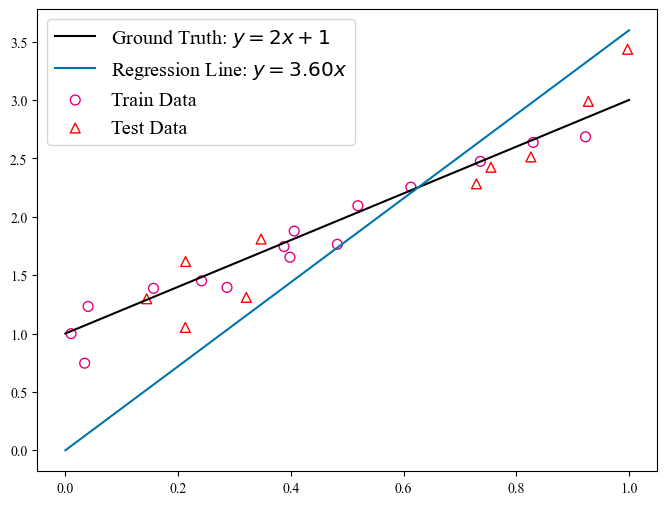

In [12]:
# Plot the regression line
y_pred = X_underlying * theta_closed_form
plt.plot(X_underlying.cpu(), y_underlying.cpu(), c='#000000', label=r"Ground Truth: $y = 2x + 1$")
plt.plot(X_underlying.cpu(), y_pred.cpu(), c='#0075ad', label=f"Regression Line: $y = {theta_closed_form:.2f}x$")
plt.scatter(X_train.cpu(), y_train.cpu(), facecolor="none", edgecolor='#e4007f', s=50, label="Train Data")
plt.scatter(X_test.cpu(), y_test.cpu(), facecolor="none", edgecolor="r", marker = '^', s=50, label="Test Data")
plt.legend(fontsize='x-large')
plt.show()

## Gradient Descent

Gradient descent is an optimization algorithm that is used to minimize some function by iteratively moving in the direction of steepest descent as defined by the negative of the gradient. The formula is as follows:

$$
\theta = \theta - \alpha \nabla_{\theta}\mathcal{L}(\theta)
$$

where $\theta$ is the parameter vector, $\alpha$ is the learning rate, and $\mathcal{L}(\theta)$ is the loss function.

Here we present an example of using the gradient descent algorithm to solve a $y = ax$-style linear regression problem without bias. The loss function is the mean squared error (MSE) function:

$$
\mathcal{L}(\theta) = \frac{1}{n}\sum_{i=1}^{n}(y_i - \theta x_i)^2
$$

where $n$ is the number of samples.

In [13]:
# Implement the Gradient Descent algorithm
def gradient_descent(X, y, learning_rate, n_epochs):
    """
    Implement the Gradient Descent algorithm
    """
    
    n_samples, n_features = X.shape
    theta = torch.zeros(n_features,1, device=device)
    
    for epoch in range(n_epochs):
        # calculate the gradient
        gradient = 2/n_samples * X.T @ (X @ theta - y)
        
        # update the parameter
        theta = theta - learning_rate * gradient
        
    return theta.item()

# Find the solution using the Gradient Descent algorithm
learning_rate = 0.1
n_epochs = 100
theta_gradient_descent = gradient_descent(X_train, y_train, learning_rate, n_epochs)
theta_gradient_descent

3.570676326751709

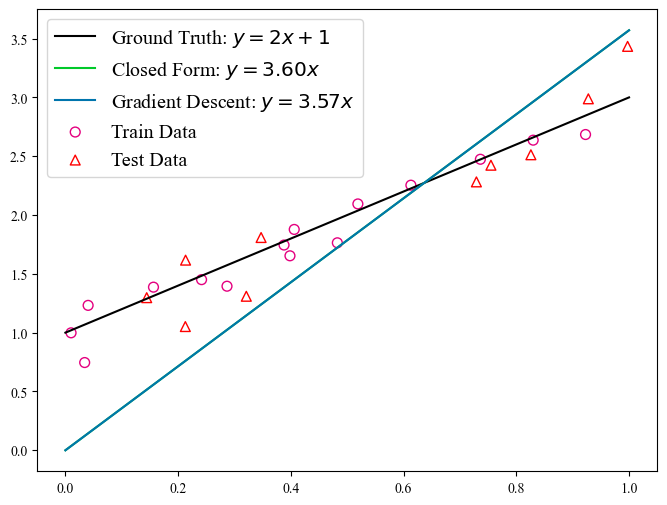

In [14]:
# Plot the regression line
y_pred = X_underlying * theta_gradient_descent
plt.plot(X_underlying.cpu(), y_underlying.cpu(), c='#000000', label=r"Ground Truth: $y = 2x + 1$")
plt.plot(X_underlying.cpu(), y_pred.cpu(), c='#00c92a', label=f"Closed Form: $y = {theta_closed_form:.2f}x$")
plt.plot(X_underlying.cpu(), y_pred.cpu(), c='#0075ad', label=f"Gradient Descent: $y = {theta_gradient_descent:.2f}x$")
plt.scatter(X_train.cpu(), y_train.cpu(), facecolor="none", edgecolor='#e4007f', s=50, label="Train Data")
plt.scatter(X_test.cpu(), y_test.cpu(), facecolor="none", edgecolor="r", marker = '^', s=50, label="Test Data")
plt.legend(fontsize='x-large')
plt.show()

# Questions

1. What metric does evaluate_rmse compute? How is it different from the standard deviation (std)? Explain in one sentence.

2. Read the parameter block at the top of data_generate.py. When D=3, W=[1.0, 0.5, -0.8], B=1, and NOISE_STD_TEST=2.0:
a) How many columns are in the generated train.txt and test_X.txt, respectively? What does the last column represent?
b) What is the approximate value of ||w||_2 for this setting?

3. When changing the model from “no bias” to “with bias,” what geometric change occurs to the regression line, and why does this usually reduce error?

# Answers
1.evaluate_rmse计算的是预测误差的均方根误差。标准差是衡量单个变量分布的离散程度；RMSE衡量的是预测和真实值之间的平均距离，而不是数据本身的波动。

2.（a）train.txt有4列，test_X.txt有三列。在 train.txt 中最后一列是目标变量 $y$，其值为：𝑦=𝑥1 ⋅ 1.0 + 𝑥2 ⋅ 0.5 + 𝑥3 ⋅ (−0.8) + 1 + noise
   (b) 约为1.375

3.添加偏置项会使回归线不再强制通过原点（0,0），而是可以整体上下平移，从而更准确地拟合数据的真实趋势，通常能显著降低误差。


# Exercise
Your task is to modify the provided code and implement both a closed-form solution and a gradient descent algorithm to solve the linear regression problem $y = ax + b$ with bias and polynomial linear regression. Concretely, you are required to:

1. Calculate the closed-form solution for the linear regression problem with bias. Implement the function `closed_form_solution_with_bias` to calculate the weight $\theta$ and bias $b$.

2. Calculate the gradient of the MSE loss function with respect to the weight and bias. Implement the function `gradient_descent_with_bias` to calculate the gradients and iteratively update the weight and bias using the gradient descent algorithm.

3. Extend the implementation to support multivariate linear regression when features are multi-dimensional.

4. Evaluate the performance of both the closed-form solution and the gradient descent algorithm on the test dataset. Implement the function evaluate to compute the RMSE of the predictions on the test data. Explain the meaning of the Root Mean Squared Error (RMSE) metric.